# *K-means* e *bisecting K-means* 

O objetivo deste projeto é realizar uma análise qualitative entre o K-means e o bisecting K-means. As bases de dados utilizadas serão a [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) e o [Wine Dataset](http://archive.ics.uci.edu/ml/datasets/Wine).

O pré-processamento e o estudo da redução de dimensionalidade foram efetuados no 

In [1]:
from sklearn import metrics
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random as rd

filepath_iris = '../data/iris.csv'

In [2]:
data = pd.read_csv(filepath_iris)
print(data.describe())

       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


## Criando agrupamento do database

Usando pandas estraimos as informações do database que utilizamos

In [3]:
data.groupby('species').agg(['mean', 'median'])
data.groupby('species').agg([np.mean, np.median])

sepal_length        sepal_width        petal_length         \
                        mean median        mean median         mean median   
species                                                                      
Iris-setosa            5.006    5.0       3.418    3.4        1.464   1.50   
Iris-versicolor        5.936    5.9       2.770    2.8        4.260   4.35   
Iris-virginica         6.588    6.5       2.974    3.0        5.552   5.55   

                petal_width         
                       mean median  
species                             
Iris-setosa           0.244    0.2  
Iris-versicolor       1.326    1.3  
Iris-virginica        2.026    2.0

E então, a partir do database, conseguimos pegar os valores verdadeiros para ser usado como dados de validação mais tarde

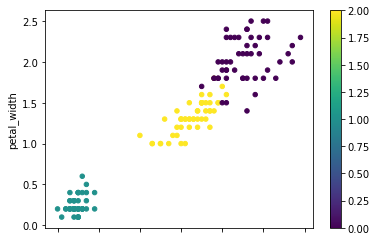

In [4]:
num = {val:i for i,val in enumerate(set(data.species))}
y_true = [num[item] for item in data.species]

data.plot.scatter(x="petal_length", y="petal_width", c=y_true, colormap='viridis')

## Definindo nossa versão do algorítimo

Basicamente o K-Means foi dividido em várias sub-funções com o intuito de facilitar o entendimento total da função.

In [5]:
def plotter(doc, ks, label):
    X,Y = zip(*doc)
    kx,ky = zip(*ks)

    plt.scatter(x=X,y=Y, marker='o', c=label)
    plt.scatter(x=kx, y=ky, marker='x', color='black', s=150)
    
def plotter2(doc):
    X,Y = zip(*doc)
    plt.scatter(x=X,y=Y, marker='o')

Usamos a princípio a distância euclidiana por ser bem fácil de ser implementada em Python

In [6]:
def euclidianDistance(p1, p2):
    return math.sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )

Criamos uma heurística que segue os seguintes critérios:
 - Se iterador maior que um máximo de iterações, retorna falso;
 - Se a deferença da distância dos centróides for menor ou igual a 0.001, são basicamente iguais então podemos contar como iguais e aumentar o contador de centroides basicmanete imóveis;
 - Se todos os centroides forem praticamente iguais, não teve alteração significativa, retorna falso para quebrar o laço;
 - Quaisquer outros resultados são verdadeiros.

In [7]:
MAX_ITER = 15
def goCondition(old_centroids, curr_centroids, itter):
    if itter >= MAX_ITER: return False    
    
    ctd = 0
    for old_centroid,curr_centroid in zip(old_centroids,curr_centroids):
        if abs(old_centroid[0]-curr_centroid[0]) <= 0.001 and\
           abs(old_centroid[1]-curr_centroid[1]) <= 0.001:
               ctd += 1
    if ctd == len(curr_centroids): return False
    
    return True

In [8]:
def calculateAllDistances(positions, centroids, distFunction=euclidianDistance):
    distances = list()
    for pos in positions:
        list_per_cent = list()
        for index, cent in enumerate(centroids):
            list_per_cent.append(distFunction(cent, pos))

        distances.append(list_per_cent)

    return distances

A função `giveOwnership()` basicamente determina quais pontos pertencem a quais centróides.

É determidado da seguinte forma:
 - Dado uma lista das distância de cada ponto até os centróides, o ponto pertence ao centróide mais próximo dele.
 
Retorna uma lista do mesmo tamanho da quantidade de itens/posições do database.

In [9]:
def giveOwnership(distances):
    label = list()
    for dist in distances:
        min_dist = min(dist)
        label.append(dist.index(min_dist))

    return label

In [10]:
def generateCentroids(list_x, list_y, k):
    (min_x, min_y) = (min(list_x)-(min(list_x)*0.2),\
                      min(list_y)-(min(list_y)*0.2))
    (max_x, max_y) = (max(list_x)+(max(list_x)*0.2),\
                      max(list_y)+(max(list_y)*0.2))

    return [(rd.uniform(min_x, max_x), rd.uniform(min_y, max_y)) for i in range(k)]

`updateCentroids()` é de certa forma peça importante para o desempenho do algorítmo no geral.

Dado que a variável `labels` é uma lista, percorre-la custaria `O(n)`, e se fossemos varrer o vetor para pegar cada índice de `labels` e seus pontos equivalentes, varreríamos esta variável _k_ vezes (quantidade de centróides), ou seja, um total de `O(kn)`.

Mas neste caso, usamos um dicionário, uma estrutura de dados "_hashable_", ou seja, forma uma tabela hash e nesse caso conseguimos acessá-las em tempo `O(1)`.
Então iteramos em cima de posições e rótulos das posições e se o rótulo não tiver no dicionário, adiciona-o e os dá o valor da posição atual, e se existir apenas adicionamos os valores dessa posição em cima de seu rótulo.
Com isso ficamos com `O(n)`

Usando deste artifício, conseguimos uma melhora de cerca de 50% na velocidade de processamento.

In [11]:
def updateCentroids(positions, labels, k):
    centroids = dict()
    for p,label in zip(positions,labels):
        if label not in centroids:
            centroids[label] = {"x":p[0], "y":p[1], "len":1}
        else:
            centroids[label]["x"] += p[0]
            centroids[label]["y"] += p[1]
            centroids[label]["len"] += 1
 
        
    return [(c['x']/c['len'], c['y']/c['len']) for c in centroids.values()]

def defineNewCentroids(S, old_centroids, dist_func):
    color = {cen:i for i,cen in enumerate(old_centroids)}
    
    centroids = dict()
    labels = []
    
    for p in S:
        distances = [(dist_func(p, centroid), centroid) for centroid in old_centroids]
        closest_centroid = min(distances, key=lambda x: x[0])[1]
        
        label = color[closest_centroid]
        labels.append(label)
        
        if label not in centroids:
            centroids[label] = {"x":p[0], "y":p[1], "len":1}
        else:
            centroids[label]["x"] += p[0]
            centroids[label]["y"] += p[1]
            centroids[label]["len"] += 1
 
    new_centroids = [(c['x']/c['len'], c['y']/c['len']) for c in centroids.values()]

    return new_centroids,labels



In [12]:
# def kmeans(list_x, list_y, k, distFunction, iter_times=50):
#     positions = list(zip(list_x, list_y))
#     curr_centroids = generateCentroids(list_x, list_y, k)
#     old_centroids = generateCentroids(list_x, list_y, k)
#     distances = calculateAllDistances(positions, curr_centroids, distFunction)
#     labels = giveOwnership(distances)

#     itter = 0
#     while goCondition(old_centroids, curr_centroids, itter, iter_times):
#         old_centroids = curr_centroids
#         curr_centroids = updateCentroids(positions, labels, k)
#         new_distances = calculateAllDistances(positions, curr_centroids, distFunction)
#         labels = giveOwnership(new_distances)

#         itter += 1

#     return labels, curr_centroids

def kmeans(S, k, dist_func):
    curr_centroids = [tuple(s) for s in rd.sample(S, k)]
    old_centroids  = [tuple(s) for s in rd.sample(S, k)]
    itter = 0
    
    while goCondition(old_centroids, curr_centroids, itter):
        old_centroids = curr_centroids       
        curr_centroids,predicted = defineNewCentroids(S, old_centroids, dist_func)
        itter += 1
        
    return predicted,old_centroids

Agora, para um máximo de iterações interna do _k-means_ igual a 15 e para um _k_ entre 1 e 30 e então armazenamos o melhor resultado dessa rodada e "plotamos".

Melhor valor para o K:   3
Obtendo uma acurácia de: 0.8641855068202222 (v_measure_score) 

Tempo: 0.26329946517944336


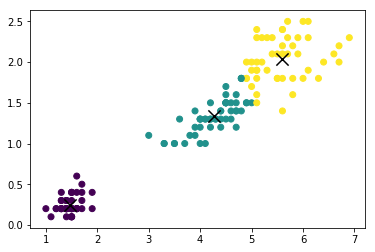

In [13]:
MAX_ITER = 15
document = list(zip(data.petal_length, data.petal_width))

best_accuracy = -1
best_centr = None
y_pred = []
best_label = []
best_k = 0

inicio = time()
for K in range(1, 30):
    y_pred, centroids = kmeans(document, K, euclidianDistance)

#     accuracy = metrics.adjusted_rand_score(y_true, y_pred)
    try:
        accuracy = metrics.v_measure_score(y_true, y_pred)
    except:
        print(y_pred)

    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_centr = centroids
        best_k = K
        best_label = y_pred

final = time()
    
print(f"Melhor valor para o K:   {best_k}\nObtendo uma acurácia de: {best_accuracy} (v_measure_score) \n\nTempo: {final-inicio}")
plotter(document, best_centr, best_label)

E claro, não poderia faltar um gráfico de relação entre K e acurácia resultante

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Time: 0.2805032730102539

Gráfico: K por Acurácia


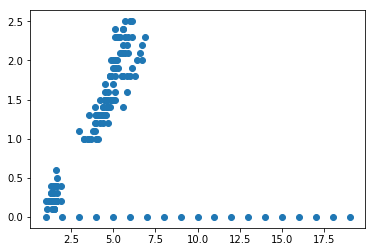

In [14]:
document = list(zip(data.petal_length, data.petal_width))

inicio = time()
for K in range(1, 20):
    y_pred, _ = kmeans(document, K, euclidianDistance)

#     accuracy = metrics.adjusted_rand_score(y_true, y_pred)
    try:
        accuracy = metrics.v_measure_score(y_true, y_pred)
    except:
        print(y_pred)

    document.append((K, accuracy))

final = time()

plotter2(document)

print(f"Time: {final-inicio}\n\nGráfico: K por Acurácia")

## Bisecting K-Means

Essa técnica utiliza o k-means tradicional para dividir o cluster inicial N vezes, achar o com maior similaridade, e repetir o processo k vezes.

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import svm
# print(iris.data)

# print(iris.target)


document = list(zip(data.petal_length, data.petal_width))


# X_train, X_test, y_train, y_test = train_test_split(document, y_true, test_size=0.4, random_state=42)
# # print(f"{X_train}\n\n{X_test}\n\n{y_train}\n\n{y_test}\n\n")


# pred_train, cents = kmeans(X_train, 3, euclidianDistance)
# accuracy_train = metrics.v_measure_score(y_train, pred_train)

# pred_test, cents = kmeans(X_test, 3, euclidianDistance)
# accuracy_test = metrics.v_measure_score(y_test, pred_test)

# print(accuracy_train)
# print(accuracy_test)
for N in range(2, 20):
    print(N)
    kfold = KFold(n_splits=N, shuffle=True, random_state=42)
    for train_index, test_index in kfold.split(document, y_true):
    #     print(f"TR_INDEX: {train_index}\n\n TE_INDEX: {test_index}")

        document_train = []
        y_train_true = []
        for i in train_index:
            document_train.append(document[i])
            y_train_true.append(y_true[i])

        pred_train, _ = kmeans(document_train, 3, euclidianDistance)
        accuracy_train = metrics.v_measure_score(y_train_true, pred_train)
        print(f"Train Acc: {accuracy_train}")

        document_test = []
        y_test_true = []
        for i in test_index:
            document_test.append(document[i])
            y_test_true.append(y_true[i])

        pred_test, _ = kmeans(document_test, 3, euclidianDistance)
        accuracy_test = metrics.v_measure_score(y_test_true, pred_test)
        print(f"Test Acc: {accuracy_test}\n")

2
Train Acc: 0.7854034750299315
Test Acc: 0.8452886175159215

Train Acc: 0.865447901982971
Test Acc: 0.7854034750299315

3
Train Acc: 0.8169664809924682
Test Acc: 0.8547055550009436

Train Acc: 0.8855129698489267
Test Acc: 0.8534410567152584

Train Acc: 0.8309697799649985
Test Acc: 0.8811111467739816

4
Train Acc: 0.8394102851300893
Test Acc: 0.867053229830299

Train Acc: 0.8508586514245466
Test Acc: 0.6773376509230102

Train Acc: 0.9364293317919108
Test Acc: 0.8622107984241079

Train Acc: 0.8546144435220909
Test Acc: 0.9067545982096721

5
Train Acc: 0.8485037945500442
Test Acc: 0.8996935451597476

Train Acc: 0.8071912308261647
Test Acc: 0.7809184381368954

Train Acc: 0.8472686964043662
Test Acc: 0.8462932564414635

Train Acc: 0.8838623143588452
Test Acc: 0.7209451152026566

Train Acc: 0.8353326993610425
Test Acc: 0.8931670521133916

6
Train Acc: 0.8528587113584152
Test Acc: 0.8852879861504027

Train Acc: 0.8126980273382076
Test Acc: 0.8901262763817137

Train Acc: 0.8621607150239938
Te

Test Acc: 0.6674193149491419

Train Acc: 0.8306363502232689
Test Acc: 1.0

Train Acc: 0.7038505085842208
Test Acc: 0.9999999999999999

Train Acc: 0.8571675352046968
Test Acc: 0.6334947514772148

Train Acc: 0.8968744026225194
Test Acc: 0.7790167298328579

Train Acc: 0.8757092051966872
Test Acc: 0.7114201837944385

Train Acc: 0.8798912631585853
Test Acc: 0.666666666666667

Train Acc: 0.8698816671473589
Test Acc: 0.48327414725642015

Train Acc: 0.8742795299524952
Test Acc: 0.7058290214460419

Train Acc: 0.8971647459815405
Test Acc: 0.7550042924856724

Train Acc: 0.8580789025296691
Test Acc: 0.9999999999999999

Train Acc: 0.8971326009261237
Test Acc: 1.0

Train Acc: 0.8585467405107419
Test Acc: 0.7790167298328579

Train Acc: 0.8408912202631985
Test Acc: 0.8095401960023788

Train Acc: 0.6992194583733372
Test Acc: 0.7471790950662619



In [16]:

from sklearn import datasets

iris = datasets.load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.4, random_state=42)
print(X_test)

[[6.1 2.8 4.7 1.2]
 [5.7 3.8 1.7 0.3]
 [7.7 2.6 6.9 2.3]
 [6.  2.9 4.5 1.5]
 [6.8 2.8 4.8 1.4]
 [5.4 3.4 1.5 0.4]
 [5.6 2.9 3.6 1.3]
 [6.9 3.1 5.1 2.3]
 [6.2 2.2 4.5 1.5]
 [5.8 2.7 3.9 1.2]
 [6.5 3.2 5.1 2. ]
 [4.8 3.  1.4 0.1]
 [5.5 3.5 1.3 0.2]
 [4.9 3.1 1.5 0.1]
 [5.1 3.8 1.5 0.3]
 [6.3 3.3 4.7 1.6]
 [6.5 3.  5.8 2.2]
 [5.6 2.5 3.9 1.1]
 [5.7 2.8 4.5 1.3]
 [6.4 2.8 5.6 2.2]
 [4.7 3.2 1.6 0.2]
 [6.1 3.  4.9 1.8]
 [5.  3.4 1.6 0.4]
 [6.4 2.8 5.6 2.1]
 [7.9 3.8 6.4 2. ]
 [6.7 3.  5.2 2.3]
 [6.7 2.5 5.8 1.8]
 [6.8 3.2 5.9 2.3]
 [4.8 3.  1.4 0.3]
 [4.8 3.1 1.6 0.2]
 [4.6 3.6 1.  0.2]
 [5.7 4.4 1.5 0.4]
 [6.7 3.1 4.4 1.4]
 [4.8 3.4 1.6 0.2]
 [4.4 3.2 1.3 0.2]
 [6.3 2.5 5.  1.9]
 [6.4 3.2 4.5 1.5]
 [5.2 3.5 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.2 4.1 1.5 0.1]
 [5.8 2.7 5.1 1.9]
 [6.  3.4 4.5 1.6]
 [6.7 3.1 4.7 1.5]
 [5.4 3.9 1.3 0.4]
 [5.4 3.7 1.5 0.2]
 [5.5 2.4 3.7 1. ]
 [6.3 2.8 5.1 1.5]
 [6.4 3.1 5.5 1.8]
 [6.6 3.  4.4 1.4]
 [7.2 3.6 6.1 2.5]
 [5.7 2.9 4.2 1.3]
 [7.6 3.  6.6 2.1]
 [5.6 3.  4.